## Retrieve the data from the API

In [8]:
from datetime import datetime

import pandas as pd
import requests
import seaborn

from ete3 import NCBITaxa


ete_db = NCBITaxa()

seaborn.set_style('white')

response = requests.get('https://www.ebi.ac.uk/eva/webservices/release/v2/stats/per-species')
response.raise_for_status()
release_metrics = response.json()

response = requests.get('https://www.ebi.ac.uk/eva/webservices/release/v1/info')
response.raise_for_status()
release_info = response.json()
version_to_date = {}
for release in release_info:
    version_to_date[release.get('releaseVersion')] = release['releaseDate'].split('T')[0]

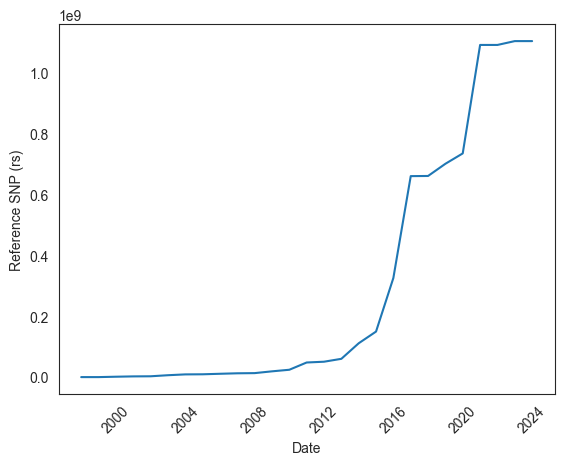

## Annotate the release metrics with release date and taxonomy lineage

In [21]:
required_ranks = ['superkingdom', 'kingdom', 'class', 'order', 'species']
all_records = []
all_project_loaded = set()
for record in release_metrics:
    # Add date of the release
    record['releaseDate'] = version_to_date[record['releaseVersion']]
    # Add information about lineage of the taxonomy
    lineage = ete_db.get_lineage(int(record.get('taxonomyId')))
    # Get the rank of each taxonomy ids
    ranks = ete_db.get_rank(lineage)
    # Get the taxonomy of the required ranks
    for required_rank in required_ranks:
        taxid_for_rank = [i for i in ranks if ranks[i] == required_rank]
        if taxid_for_rank:
            # Get the scientific names of the rank
            sci_name_of_required_rank = ete_db.get_taxid_translator(taxid_for_rank)[taxid_for_rank[0]]
            record[required_rank] = sci_name_of_required_rank
    all_records.append(record)
df = pd.DataFrame.from_dict(all_records)
df['Date'] = pd.to_datetime(df['releaseDate'], format='%Y-%m-%d')


/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 563191 was translated into 187327
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469587 was translated into 817
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469586 was translated into 818
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


## Only keep the relevant label from the class level

In [22]:
df['label'] = df['class']
df.loc[df.superkingdom != 'Eukaryota', 'label'] = 'Others'

# Change all the label not in the list bellow to others
accepted_classes = {'Aves': 'Birds','Insecta':'Insects','Actinopteri': 'Fish','Mammalia': 'Mammals','Magnoliopsida': 'Flowering plants'}

# Check ~ which somehow means "NOT IN" in pandas
df.loc[~df['label'].isin(accepted_classes), 'label'] = 'Others'
df = df.replace({'label': accepted_classes})

df = df[df.label != 'Others']
# df = df[df.label != 'Animals']

# Group by class and releaseDate to add up all rs from a specific class
eva_metrics_per_class = df.groupby(['label', 'Date'])[["currentRs"]].sum().reset_index()
eva_metrics_per_class = eva_metrics_per_class.rename(columns={'currentRs': 'Reference SNP (rs)'})
eva_metrics_per_class



,label,Date,Reference SNP (rs)
0,Birds,2019-11-12,25515682
1,Birds,2020-11-03,25510830
2,Birds,2022-02-24,59854553
3,Birds,2022-11-21,60399128
4,Birds,2023-08-31,59933485
5,Birds,2024-07-08,97260706
6,Birds,2025-04-09,131211539
7,Fish,2019-11-12,18597026
8,Fish,2020-11-03,48087022
9,Fish,2022-02-24,55578268


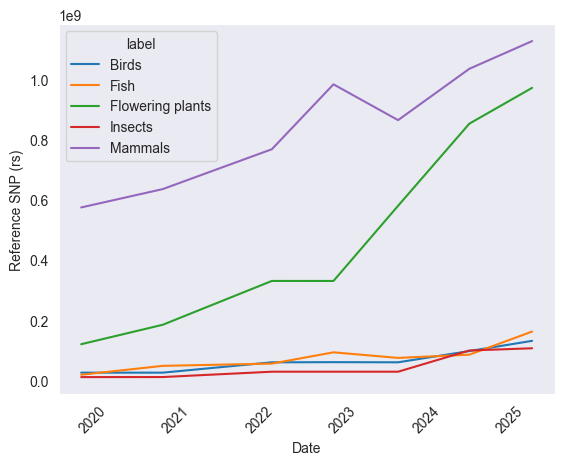

In [23]:
g2 = seaborn.lineplot(data=eva_metrics_per_class, x='Date', y='Reference SNP (rs)', hue='label')
g2.tick_params(axis='x', rotation=45)
g2.grid(False)

[Text(0.5, 0, 'common xlabel'), Text(0, 0.5, 'Reference SNP (Billion)')]

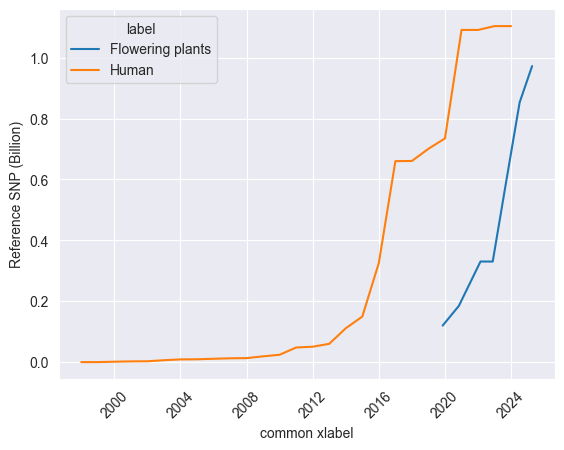

In [35]:
dbsnp_metrics = pd.read_csv('dbsnp_release_metrics_per_year.tsv', sep='\t')
dbsnp_metrics['Date'] = pd.to_datetime(dbsnp_metrics['Year'], format='%Y')
dbsnp_metrics['label'] = 'Human'
eva_metrics_per_plants = eva_metrics_per_class.loc[eva_metrics_per_class['label'] == 'Flowering plants', ['Date', 'Reference SNP (rs)', 'label']]

metrics = pd.concat([eva_metrics_per_plants, dbsnp_metrics], axis='rows')
metrics['Reference SNP (rs)'] = metrics['Reference SNP (rs)'] / 1000000000

g = seaborn.lineplot(data=metrics, x='Date', y='Reference SNP (rs)', hue='label')
g.tick_params(axis='x', rotation=45)
g.set(xlabel='common xlabel', ylabel='Reference SNP (Billion)')
# g.grid(False)